# Rigol Waveform Creator
## Jan 2016
This is an updated interface to the DG4102 arb generator. It makes use of the usbtmc python library installed via `dnf install python3-usbtmc`. The basic interface is to create a handle to the instrument and then use `write`, `read`, or `ask` methods on the handle.

In [1]:
import numpy
import matplotlib.pyplot as plt
import usbtmc
%matplotlib inline

In [2]:
# this connects to the instrument directly using it's USB ID:
handle = usbtmc.Instrument(int("1AB1",16),int("0641",16))

In [4]:
# This will probably timeout the first time. Just run it again
handle.ask('*IDN?')

'Rigol Technologies,DG4102,DG4B151400125,00.01.04'

In [5]:
# set voltage high
handle.write(":VOLT:HIGH 2.00")

In [9]:
handle.write(":SOUR1:APPL:USER 100,10,5,0")

Now do some waveform creation:

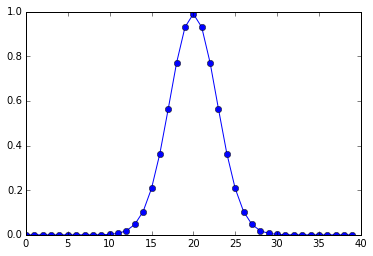

In [11]:
N = 40
x = numpy.array(range(40))
data = 0.99*numpy.exp(-((x-20)/4)**2)
plt.plot(data,"o-")

In [12]:
handle.write(":DATA:POINTS VOLATILE,{}".format(N))

In [13]:
handle.ask(":DATA:POINTS? VOLATILE")

'40'

## Now to reverse engineer the VCA response:

In [14]:
def VfromI(Intensity):
    """Implement the inverted response function. See data fit in google drive AOM folder."""
    V = (.0039757327 + (.0039757327 ** 2 + 4 *.0078826605 * Intensity) ** (1/2))/(2*.0078826605)
    return V

In [15]:
voltages = VfromI(data)
floats = voltages/voltages.max() # values scaled to 0-1.0
floats

array([ 0.04400391,  0.04400391,  0.04400394,  0.04400422,  0.04400635,
        0.04402087,  0.04410762,  0.0445589 ,  0.04653897,  0.05331964,
        0.07026781,  0.10284296,  0.15614279,  0.23459692,  0.34019267,
        0.47018914,  0.61544563,  0.76037465,  0.88514423,  0.96992563,
        1.        ,  0.96992563,  0.88514423,  0.76037465,  0.61544563,
        0.47018914,  0.34019267,  0.23459692,  0.15614279,  0.10284296,
        0.07026781,  0.05331964,  0.04653897,  0.0445589 ,  0.04410762,
        0.04402087,  0.04400635,  0.04400422,  0.04400394,  0.04400391])

In [16]:
handle.write(":DATA:POINTS VOLATILE,40")

In [17]:
numPoints = int(handle.ask(":DATA:POINTS? VOLATILE"))
numPoints

40

In [18]:
for i in range(1,len(floats)-1):
    command_string = ":DATA:VAL VOLATILE," + str(i) + "," + str(int(0.9*16383*floats[i]))
    check_string = ":DATA:VAL? VOLATILE," + str(i)
    #print(command_string)
    handle.write(command_string)
    #print(handle.ask(check_string))

['647', '647', '647', '647', '648', '649', '656', '685', '786', '1036', '1515', '2302', '3459', '5016', '6932', '9074', '11210', '13051', '14301', '14744', '14301', '13051', '11210', '9074', '6932', '5016', '3459', '2302', '1515', '1036', '786', '685', '656', '649', '648', '647', '647', '647', '0', '0']
40


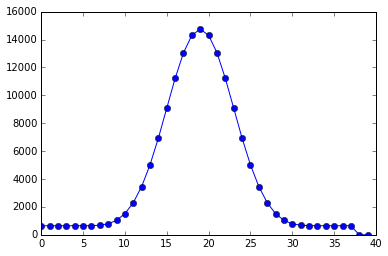

In [19]:
# Check what the instrument memory holds
# For some reason, it can only pull 38 values.
wave = []
# add 1 to numPoints to account for range function
for i in range(1,numPoints+1):
    #sleep(0.2)
    wave.append( handle.ask(":DATA:VALUE? VOLATILE,{}".format(i)) )
    
print(wave)
print(len(wave))
plt.plot(wave,"o-")

In [ ]:
handle.close()